# Телеком 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

*BeginDate* - дата начала пользования услугами  
*EndDate* - дата окончания пользования услугами  
*Туре* - тип оплаты: ежемесячный, годовой и тд 
*РaperlessBilling* - электронный платёжный документ   
*Payment Method* - способ оплаты  
*MonthlyCharges* - ежемесячные траты на услуги по договору  
*Total Charges* - всего потрачено денег на услуги  
*Dependents* - наличие иждивенцев   
*Senior Citizen* - наличие пенсионного статуса по возрасту   
*Partner* - наличие супруга(и)    
*Multiple Lines* - наличие возможности ведения параллельных линий во время звонка     
Целевой признак формируем самостоятельно с помощью End Date     

**План работы:   
    1.Ознакомление с данными  
    2.Анализ пропусков и их устранение   
    3.Преобразование типов данных  
    4.Анализ дисбаланса классов  
    5.Исследование корреляции  
    6.Обучение моделей и подбор гиперпараметров  
    7. Выбор лучшей модели  
    7. Анализ важности признаков лучшей модели  
    8. Нахождение значения метрики roc_auc и accuracy**

In [1]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import shap 
import phik
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV)
from sklearn.preprocessing import (OneHotEncoder,OrdinalEncoder)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import (accuracy_score, roc_auc_score,roc_curve)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (15,15)

In [4]:
try:
    contract_new=pd.read_csv(r"C:\Users\Admin\Desktop\contract_new.csv",index_col=[0])
    personal_new=pd.read_csv(r"C:\Users\Admin\Desktop\personal_new.csv",index_col=[0])
    internet_new=pd.read_csv(r"C:\Users\Admin\Desktop\internet_new.csv",index_col=[0])
    phone_new=pd.read_csv(r"C:\Users\Admin\Desktop\phone_new.csv",index_col=[0])
except:
    contract_new=pd.read_csv('/datasets/contract_new.csv',index_col=[0])
    personal_new=pd.read_csv('/datasets/personal_new.csv',index_col=[0])
    internet_new=pd.read_csv('/datasets/internet_new.csv',index_col=[0])
    phone_new=pd.read_csv('/datasets/phone_new.csv',index_col=[0])

## Предобработка данных

### изучение таблицы contract_new

In [5]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [6]:
contract_new.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
contract_new['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Видим, что 55% клиентов платят помесячно. 

In [8]:
contract_new['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [9]:
contract_new['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Преобразуем тип столбца BeginDate в datetime

In [10]:
contract_new['BeginDate']=pd.to_datetime(contract_new['BeginDate'], format='%Y.%m.%d')


In [11]:
contract_new['BeginDate'].value_counts()

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

In [12]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [13]:
contract_new['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-10-01       1
2014-11-01       1
2014-06-01       1
Name: EndDate, Length: 67, dtype: int64

In [14]:
actual_date=pd.to_datetime('2020-02-01', format='%Y.%m.%d')

In [15]:
contract_new['EndDate']=contract_new['EndDate'].replace('No',actual_date)

Создадим целевой признак на основе данных из столбца EndDate

In [16]:
def target(contract_new):
    if contract_new['EndDate']==actual_date:
        return 0
    else:
        return 1 

In [17]:
contract_new['IsLeave']=contract_new.apply(target, axis=1)

In [18]:
contract_new['EndDate']=pd.to_datetime(contract_new['EndDate'], format='%Y.%m.%d')

In [19]:
contract_new['EndDate'].value_counts()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2015-04-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

In [20]:
def DaysInCompany(contract_new):
    if contract_new['EndDate']==actual_date:
         return (actual_date-contract_new['BeginDate']).days
    else:
        return (contract_new['EndDate']-contract_new['BeginDate']).days
   

In [21]:
contract_new['DaysInCompany']=contract_new.apply(DaysInCompany, axis=1)

In [22]:
contract_new['DaysInCompany'].value_counts()

2191    265
153     249
92      243
31      236
123     236
       ... 
121       1
2253      1
424       1
1309      1
547       1
Name: DaysInCompany, Length: 251, dtype: int64

In [23]:
contract_new['DaysInCompany'].isna().sum()

0

In [24]:
contract_new.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


Признак EndDate больше не нужен, удаляем его чтобы избежать утечки целевого признака. 

In [25]:
contract_new=contract_new.drop('EndDate',axis=1)

In [26]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   Type              7043 non-null   object        
 2   PaperlessBilling  7043 non-null   object        
 3   PaymentMethod     7043 non-null   object        
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7043 non-null   object        
 6   IsLeave           7043 non-null   int64         
 7   DaysInCompany     7043 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 495.2+ KB


In [27]:
contract_new['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
1007.5      4
           ..
2649.58     1
89.0        1
907.15      1
200.9       1
4245.75     1
Name: TotalCharges, Length: 6658, dtype: int64

Имеющая пустые значения в TotalCharges

In [28]:
contract_new[contract_new['TotalCharges'] == ' ']

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany
customerID,,,,,,,,
4472-LVYGI,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
3115-CZMZD,2020-02-01,Two year,No,Mailed check,20.25,,0,0
5709-LVOEQ,2020-02-01,Two year,No,Mailed check,80.85,,0,0
4367-NUYAO,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1371-DWPAZ,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
7644-OMVMY,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3213-VVOLG,2020-02-01,Two year,No,Mailed check,25.35,,0,0
2520-SGTTA,2020-02-01,Two year,No,Mailed check,20.00,,0,0
2923-ARZLG,2020-02-01,One year,Yes,Mailed check,19.70,,0,0


In [29]:
contract_new.loc[contract_new['TotalCharges']==' ', 'TotalCharges'] = contract_new['MonthlyCharges']

Можно либо заменить их нулями, либо заполнить значением из MonthlyCharges

In [30]:
contract_new['TotalCharges']=pd.to_numeric(contract_new['TotalCharges'],errors='coerce' )

In [31]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   Type              7043 non-null   object        
 2   PaperlessBilling  7043 non-null   object        
 3   PaymentMethod     7043 non-null   object        
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7043 non-null   float64       
 6   IsLeave           7043 non-null   int64         
 7   DaysInCompany     7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 753.2+ KB


In [32]:
contract_new['TotalCharges'].isna().sum()

0

In [33]:
contract_new.index.nunique ()

7043

### Изучение таблицы personal_new

In [34]:
personal_new.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [35]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [36]:
personal_new['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [37]:
personal_new['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [38]:
personal_new['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [39]:
personal_new['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [40]:
personal_new.index.nunique ()

7043

Признаки SeniorCitizen, gender и Partner распределены примерно по ровну.   
А вот признак Dependents (наличие иждивенцев) имеет перекос. Людей, у которых есть  иждивенцев, в два раза меньше.

### Изучение таблицы internet_new

In [41]:
internet_new.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [42]:
internet_new.index.nunique()

5517

### Изучение таблицы phone_new

In [43]:
phone_new.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [44]:
phone_new['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [45]:
phone_new.index.nunique()

6361

In [46]:
phone_new['MultipleLines'].isna().sum()

0

### Объединение таблиц

Объединим все таблицы в одну по индексу customerID

In [47]:
data=personal_new.merge(contract_new, on='customerID', how='left')

In [48]:
data=data.merge(phone_new, on='customerID', how='left')

In [49]:
data=data.merge(internet_new, on='customerID', how='left')

In [50]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,One year,No,Mailed check,56.95,2071.84,0,1036,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,No,Fiber optic,No,No,No,No,No,No


In [51]:
data.shape

(7043, 20)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
 10  IsLeave           7043 non-null   int64         
 11  DaysInCompany     7043 non-null   int64         
 12  MultipleLines     6361 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

Заполним пропуски, которые возникли в результате объединения таблиц, заменяем на No, так как клиенты не пользуются определенными услугами. 

In [53]:
list=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
data[list]=data[list].fillna('No')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
 10  IsLeave           7043 non-null   int64         
 11  DaysInCompany     7043 non-null   int64         
 12  MultipleLines     7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

In [55]:
data['IsLeave'].value_counts()

0    5942
1    1101
Name: IsLeave, dtype: int64

Наблюдаем дисбаланс классов, но метрика roc_auc не чувствительна к дисбалансу классов. 

In [56]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,One year,No,Mailed check,56.95,2071.84,0,1036,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,No,Fiber optic,No,No,No,No,No,No


Индекс customerID нам больше не нужен, удаляем. 

In [57]:
data = data.reset_index(drop=True)

In [58]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Female,0,Yes,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,No,DSL,No,Yes,No,No,No,No
1,Male,0,No,No,2017-04-01,One year,No,Mailed check,56.95,2071.84,0,1036,No,DSL,Yes,No,Yes,No,No,No
2,Male,0,No,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,No,DSL,Yes,Yes,No,No,No,No
3,Male,0,No,No,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,No,DSL,Yes,No,Yes,Yes,No,No
4,Female,0,No,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,No,Fiber optic,No,No,No,No,No,No


### Исследование распредедения признаков

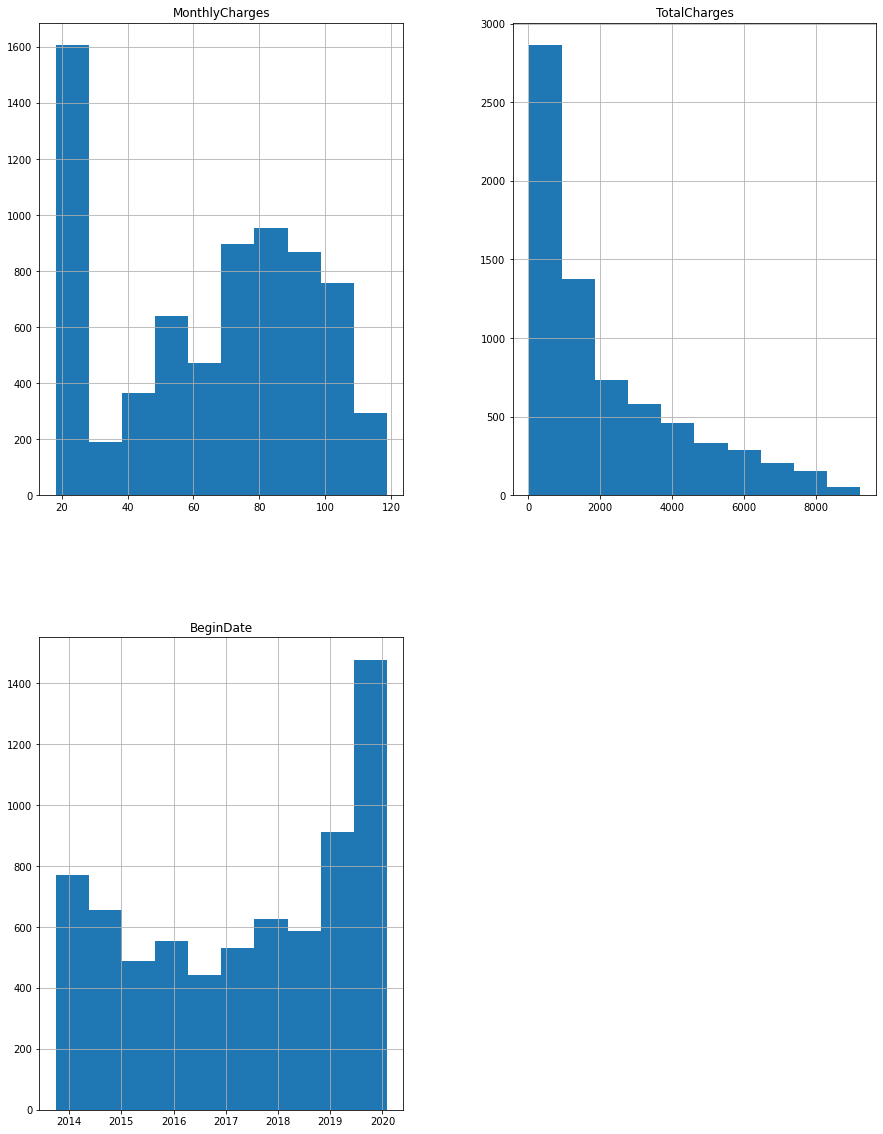

In [59]:
data[['MonthlyCharges','TotalCharges','BeginDate']].hist(figsize=(15, 20));

Можно заменить про графикам, что с середины 2019 года пришло много новых клиентов.  
А так как клиенты пришли недавно, то у них небольшие суммы TotalCharges

In [60]:
data[data["BeginDate"]>'2019-01-01']

,gender,SeniorCitizen,Partner,Dependents,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Female,0,Yes,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,No,DSL,No,Yes,No,No,No,No
2,Male,0,No,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,No,DSL,Yes,Yes,No,No,No,No
4,Female,0,No,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,No,Fiber optic,No,No,No,No,No,No
5,Female,0,No,No,2019-03-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
7,Female,0,No,No,2019-04-01,Month-to-month,No,Mailed check,29.75,300.48,0,306,No,DSL,Yes,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7030,Female,0,No,No,2019-12-01,Month-to-month,Yes,Mailed check,20.05,40.10,0,62,No,No,No,No,No,No,No,No
7032,Male,1,No,No,2019-10-01,Month-to-month,Yes,Electronic check,75.75,303.00,0,123,Yes,Fiber optic,No,No,No,No,No,No
7036,Female,0,No,No,2019-02-01,One year,No,Electronic check,60.65,727.80,0,365,No,DSL,No,Yes,Yes,Yes,Yes,Yes
7040,Female,0,Yes,Yes,2019-03-01,Month-to-month,Yes,Electronic check,29.60,325.60,0,337,No,DSL,Yes,No,No,No,No,No


In [61]:
data=data.drop('BeginDate',axis=1)

###  Иследование корреляции

In [62]:
data.phik_matrix()

interval columns not set, guessing: ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'IsLeave', 'DaysInCompany']


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsLeave,DaysInCompany,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.000000,1.000000,0.016992,0.324576,0.086231,0.242133,0.292725,0.304985,0.137707,0.086159,0.063315,0.221313,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141
Partner,0.000000,0.016992,1.000000,0.652122,0.179736,0.013218,0.243008,0.203545,0.381042,0.226688,0.453688,0.220101,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011
Dependents,0.000000,0.324576,0.652122,1.000000,0.147680,0.172593,0.224903,0.184366,0.082134,0.046871,0.198729,0.033103,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999
Type,0.000000,0.086231,0.179736,0.147680,1.000000,0.106860,0.277462,0.388444,0.468471,0.094015,0.634155,0.065498,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608
PaperlessBilling,0.000000,0.242133,0.013218,0.172593,0.106860,1.000000,0.370495,0.467812,0.203144,0.083398,0.026799,0.252972,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551
PaymentMethod,0.000000,0.292725,0.243008,0.224903,0.277462,0.370495,1.000000,0.399526,0.335175,0.214832,0.350964,0.339313,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907
MonthlyCharges,0.008175,0.304985,0.203545,0.184366,0.388444,0.467812,0.399526,1.000000,0.711029,0.226280,0.387727,0.675883,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307
TotalCharges,0.000000,0.137707,0.381042,0.082134,0.468471,0.203144,0.335175,0.711029,1.000000,0.304287,0.847414,0.572584,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671
IsLeave,0.008581,0.086159,0.226688,0.046871,0.094015,0.083398,0.214832,0.226280,0.304287,1.000000,0.374569,0.261237,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232


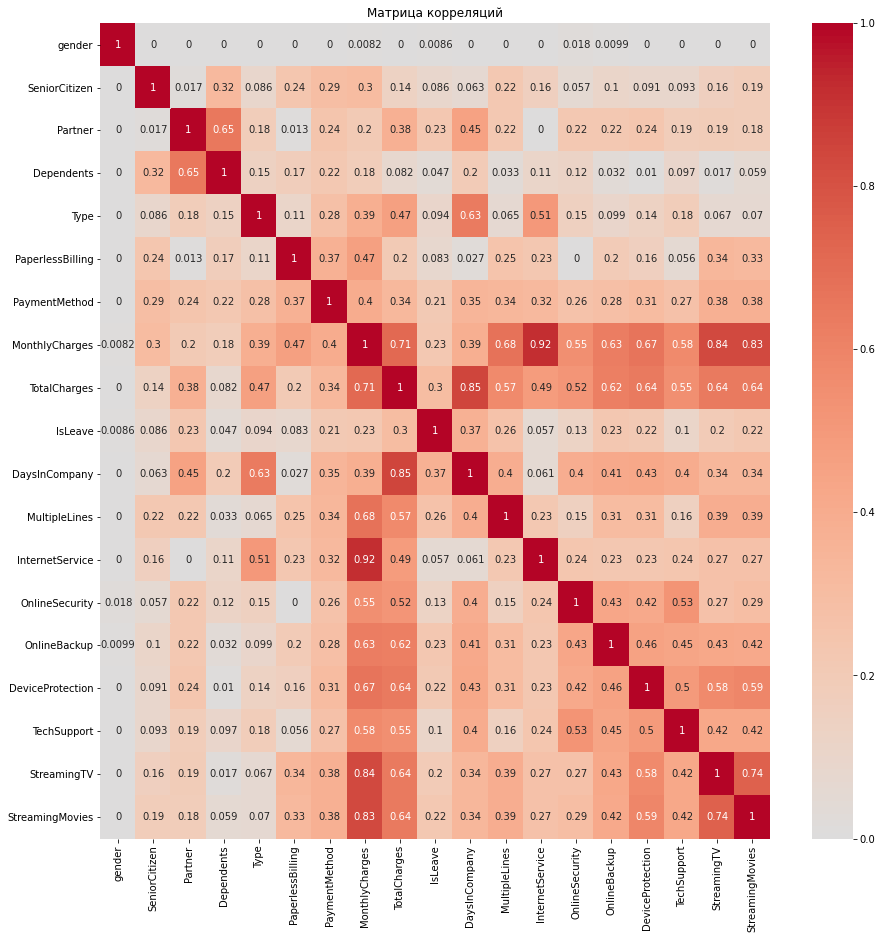

In [63]:
sns.heatmap(data.phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','DaysInCompany']),annot=True,cmap='coolwarm', center=0).set(title='Матрица корреляций');

Убираем признак TotalCharges,чтобы избежать утечки целевого признака

In [64]:
data=data.drop('TotalCharges',axis=1)

## CatBoostClassifier

В качестве первой модели рассмотрим CatBoostClassifier, она хорошо работает с категориальными признаками и не требуем тщательной подготовки данных перед обучением. 

In [65]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop('IsLeave', axis=1), data.IsLeave, test_size=0.25, random_state=220523)
cat_features = ['gender', 'SeniorCitizen', 'Partner',
                'Dependents', 'Type', 'PaperlessBilling','PaymentMethod','MultipleLines','InternetService',
               'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

In [66]:
features_train_new=features_train.copy()
features_valid_new=features_valid.copy()
target_train_new=target_train.copy()
target_valid_new=target_valid.copy()

In [67]:
features_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'DaysInCompany',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [68]:
model_CatBoostClassifier= CatBoostClassifier(random_state = 220523,loss_function="Logloss",learning_rate=0.1)
parametrs = {'depth' : range(1, 5, 1),
             'iterations' :range(10, 300, 10),
             #'learning_rate':np.arange(0.0001, 0.5, 0.0001)
              }
grid = RandomizedSearchCV(model_CatBoostClassifier, parametrs, cv=3, scoring='roc_auc',n_jobs=-1)

best_model=grid.fit(features_train, target_train,cat_features=cat_features, verbose=50)

0:	learn: 0.6334201	total: 50.6ms	remaining: 11.1s
50:	learn: 0.3277563	total: 187ms	remaining: 621ms
100:	learn: 0.3097774	total: 324ms	remaining: 382ms
150:	learn: 0.2946493	total: 465ms	remaining: 212ms
200:	learn: 0.2853016	total: 607ms	remaining: 57.4ms
219:	learn: 0.2802015	total: 661ms	remaining: 0us
0:	learn: 0.6341094	total: 3.38ms	remaining: 741ms
50:	learn: 0.3357778	total: 142ms	remaining: 469ms
100:	learn: 0.3212411	total: 270ms	remaining: 318ms
150:	learn: 0.3082532	total: 417ms	remaining: 190ms
200:	learn: 0.2948575	total: 564ms	remaining: 53.3ms
219:	learn: 0.2910446	total: 615ms	remaining: 0us
0:	learn: 0.6307207	total: 3.17ms	remaining: 693ms
50:	learn: 0.3276072	total: 135ms	remaining: 446ms
100:	learn: 0.3128448	total: 270ms	remaining: 318ms
150:	learn: 0.2890888	total: 421ms	remaining: 192ms
200:	learn: 0.2748920	total: 562ms	remaining: 53.2ms
219:	learn: 0.2689420	total: 613ms	remaining: 0us
0:	learn: 0.6480088	total: 1.31ms	remaining: 116ms
50:	learn: 0.3483949	t

Найдем значение метрики ROC-AUC для модели CatBoostClassifier

In [69]:
print('ROC-AUC =',round(best_model.best_score_,4))

ROC-AUC = 0.8675


## RandomForestClassifier

### Кодировка категориальных признаков

In [70]:
enc = OrdinalEncoder()
enc.fit(features_train[cat_features])

features_train[cat_features] = enc.transform(features_train[cat_features])
features_valid[cat_features] = enc.transform(features_valid[cat_features])

In [71]:
features_train.head()
features_valid.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,DaysInCompany,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
6551,0.0,0.0,1.0,0.0,1.0,1.0,2.0,96.00,1918,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
5645,1.0,0.0,1.0,0.0,1.0,1.0,1.0,66.15,1949,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2783,0.0,0.0,1.0,0.0,0.0,1.0,2.0,94.10,1310,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4792,0.0,1.0,1.0,0.0,1.0,1.0,2.0,106.25,2010,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
4422,1.0,0.0,0.0,0.0,1.0,1.0,0.0,97.00,914,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


### Масштабирование количественных признаков

In [72]:
numeric= ['MonthlyCharges','DaysInCompany']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])  
print(features_train.head())

      gender  SeniorCitizen  Partner  Dependents  Type  PaperlessBilling  \
6446     1.0            1.0      1.0         1.0   1.0               1.0   
5306     1.0            0.0      1.0         1.0   0.0               1.0   
2164     1.0            0.0      1.0         1.0   2.0               1.0   
4076     1.0            0.0      1.0         0.0   2.0               1.0   
883      0.0            0.0      1.0         0.0   1.0               1.0   

      PaymentMethod  MonthlyCharges  DaysInCompany  MultipleLines  \
6446            0.0        0.832674       1.251417            1.0   
5306            2.0        0.626683      -1.197416            1.0   
2164            1.0        1.206449       1.785043            0.0   
4076            1.0        1.148306       1.785043            1.0   
883             2.0        1.543676       1.652002            1.0   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
6446              1.0             1.0           1.0    

### Обучение модели RandomForestClassifier

In [73]:

model_RandomForestClassifier = RandomForestClassifier(random_state = 220523, verbose = 50)
parametrs = {'max_depth' : range(1, 10, 1),
              'n_estimators' : range(10, 300, 10)
               }
grid = RandomizedSearchCV(model_RandomForestClassifier, parametrs, cv=3, scoring='roc_auc',n_jobs=-1)

grid.fit(features_train, target_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 150
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 150
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 150
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
building tree 4 of 150
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
building tree 5 of 150
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
building tree 6 of 150
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
building tree 7 of 150
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
building tree 8 of 150
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
building tree 9 of 150
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining: 

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=220523,
                                                    verbose=50),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 10),
                                        'n_estimators': range(10, 300, 10)},
                   scoring='roc_auc')

In [74]:
print('ROC-AUC =',round(grid.best_score_,4))

ROC-AUC = 0.8189


## Выбор лучшей модели и тестирование

По значению метрики ROC-AUC делаем вывод, что наилучшей моделью является CatBoostClassifier.   
Найдем значение метрики ROC-AUC на тестовой выборке для модели CatBoostClassifier.

In [75]:
probabilities_valid = best_model.predict_proba(features_valid_new)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid_new,probabilities_one_valid)
print('ROC-AUC final = ',round(auc_roc,4))

ROC-AUC final =  0.9114


In [76]:
best_model.best_params_

{'iterations': 290, 'depth': 4}

Также найдем значение метрики accuracy_score  для модели CatBoostClassifier.

In [77]:
predictions=best_model.predict(features_valid_new)
print('accuracy_score = ',round(accuracy_score(target_valid_new, predictions),4))

accuracy_score =  0.9091


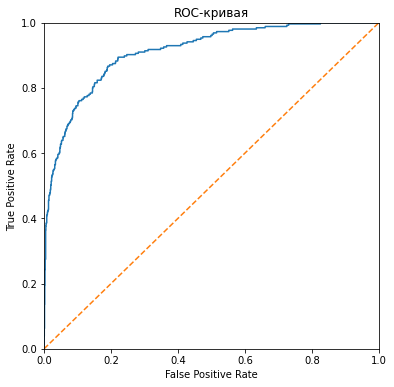

In [78]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Чем больше площадь под кривой, тем лучше. Как видно по графику, модель хорошо предсказыват положительный класс (событие: уход клиента). 

Проанализируем важность признаков

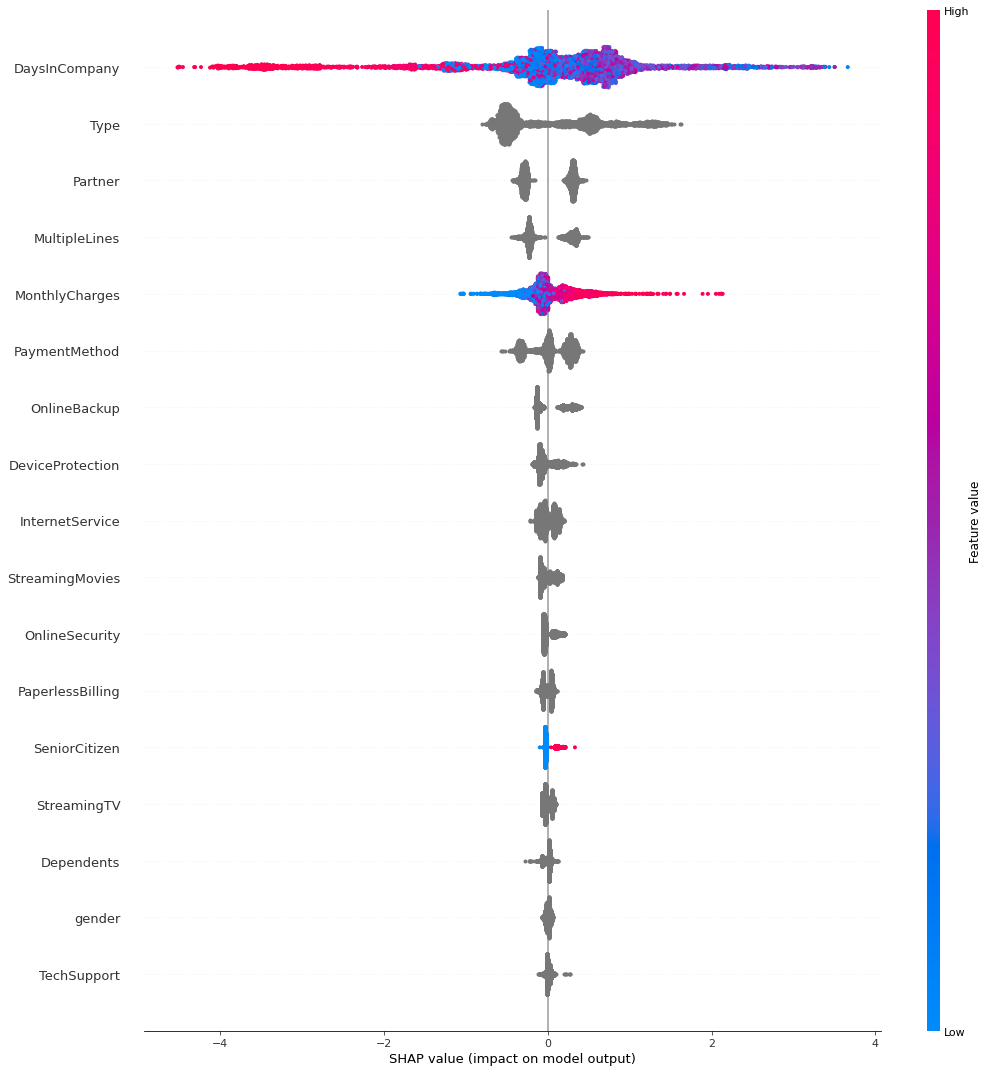

In [79]:

shap_test = shap.TreeExplainer(best_model.best_estimator_).shap_values(features_train_new)

shap.summary_plot(shap_test, features_train_new, max_display=25, plot_size=None)

По графику можно заметить:     
    Чем выше ежемесячные траты на услуги по договору (MonthlyCharges), тем выше вероятность ухода клиента.     
    Total Charges - всего потрачено денег на услуги. Чем больше потрачено, тем меньше вероятность ухода клиента.   
    То есть если клиент с нами давно и ежемесячный платеж не большой, то скорее всего клиент не уйдет.

In [80]:
print(confusion_matrix(target_valid_new, predictions))

[[1485   21]
 [ 139  116]]


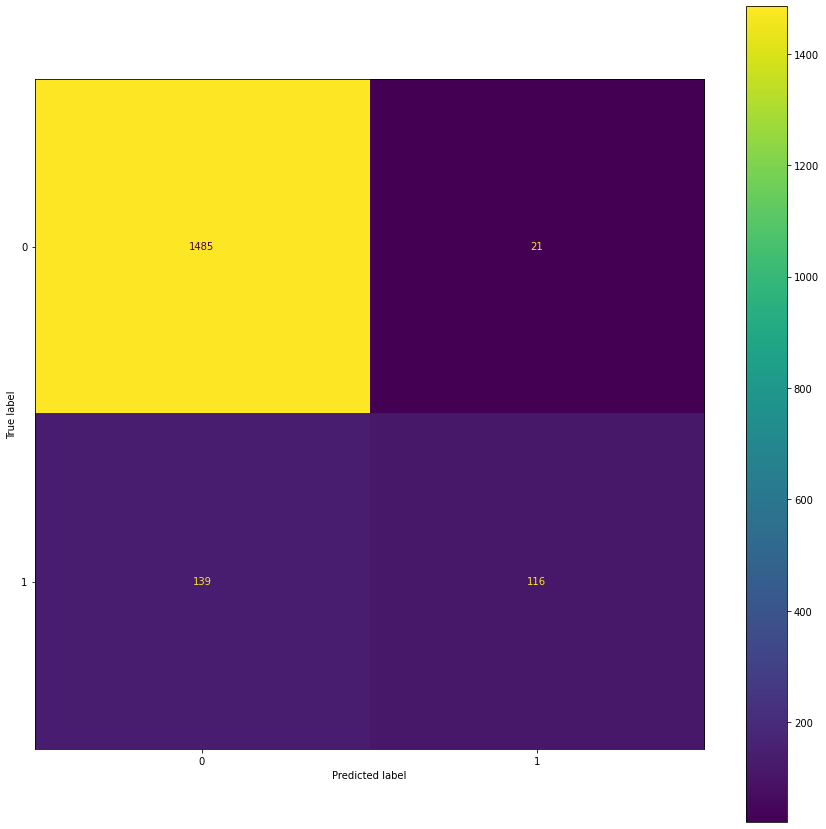

In [81]:
cm = confusion_matrix(target_valid_new, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Модель  часто ошибочно относит объект к отрицательному классу

Отчет:   

Ключевыми шагами работы были:  
- предобработка данных   
- создание новых признаков на основе имеющихся  
- анализ матрицы корреляции  
- выбор моделей для обучения  
- обучение моделей с использованием кросс валидации 

Удалось выполнить все пункты намеченного плана.  

Были трудности на этапе преобраработки данных, первоначально неверно создала признак DaysInCompany ("Число дней в компании"). Было исправлено путём анализа неправильных результатов работы модели и поиска ошибки.
Также были трудности с интерпретация матрицы корреляции - удалось решить корректной настройкой `interval_cols`.

Чтобы у моделей не было привязки к дате, признак "BeginDate" был заменен на DaysInCompany ("Число дней в компании").  
Также был убран признак TotalCharges, так как он приводил к утечке целевого признака.  
Целевой бинарный признак IsLeave был создан на основе признака EndDate, соответственно признак EndDate был удален из датасета.   
Для корректной работы моделей в данных были заполнены пропуски и изменены типы данных.   

Итоговый список признаков модели для обучения:

- gender
- SeniorCitizen
- Partner
- Dependents
- Type
- PaperlessBilling
- PaymentMethod
- MonthlyCharges
- DaysInCompany
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies

Для модели CatboostClassifier было необходимо занести категориальные признаки в параметр cat_features.  
Для модели RandomForestClassifier на этапе подготовки данных потребовалось закодировать категориальные признаки с помощью OrdinalEncoder.  
Также было необходимо выполнить масштабирование количественных признаков.  

В данных дисбаланс классов(1 к 5), который некритичен с учетом использования метрики roc_auc для оценки качества модели.   
  
  
Лучшей моделью выбрана CatBoostClassifier c параметрами iterations: 240 , depth: 4.    
Значение метрики roc_auc на тестовой выборке - 0.9.  
Значение метрики accuracy_score на тестовой выборке -  0.9  

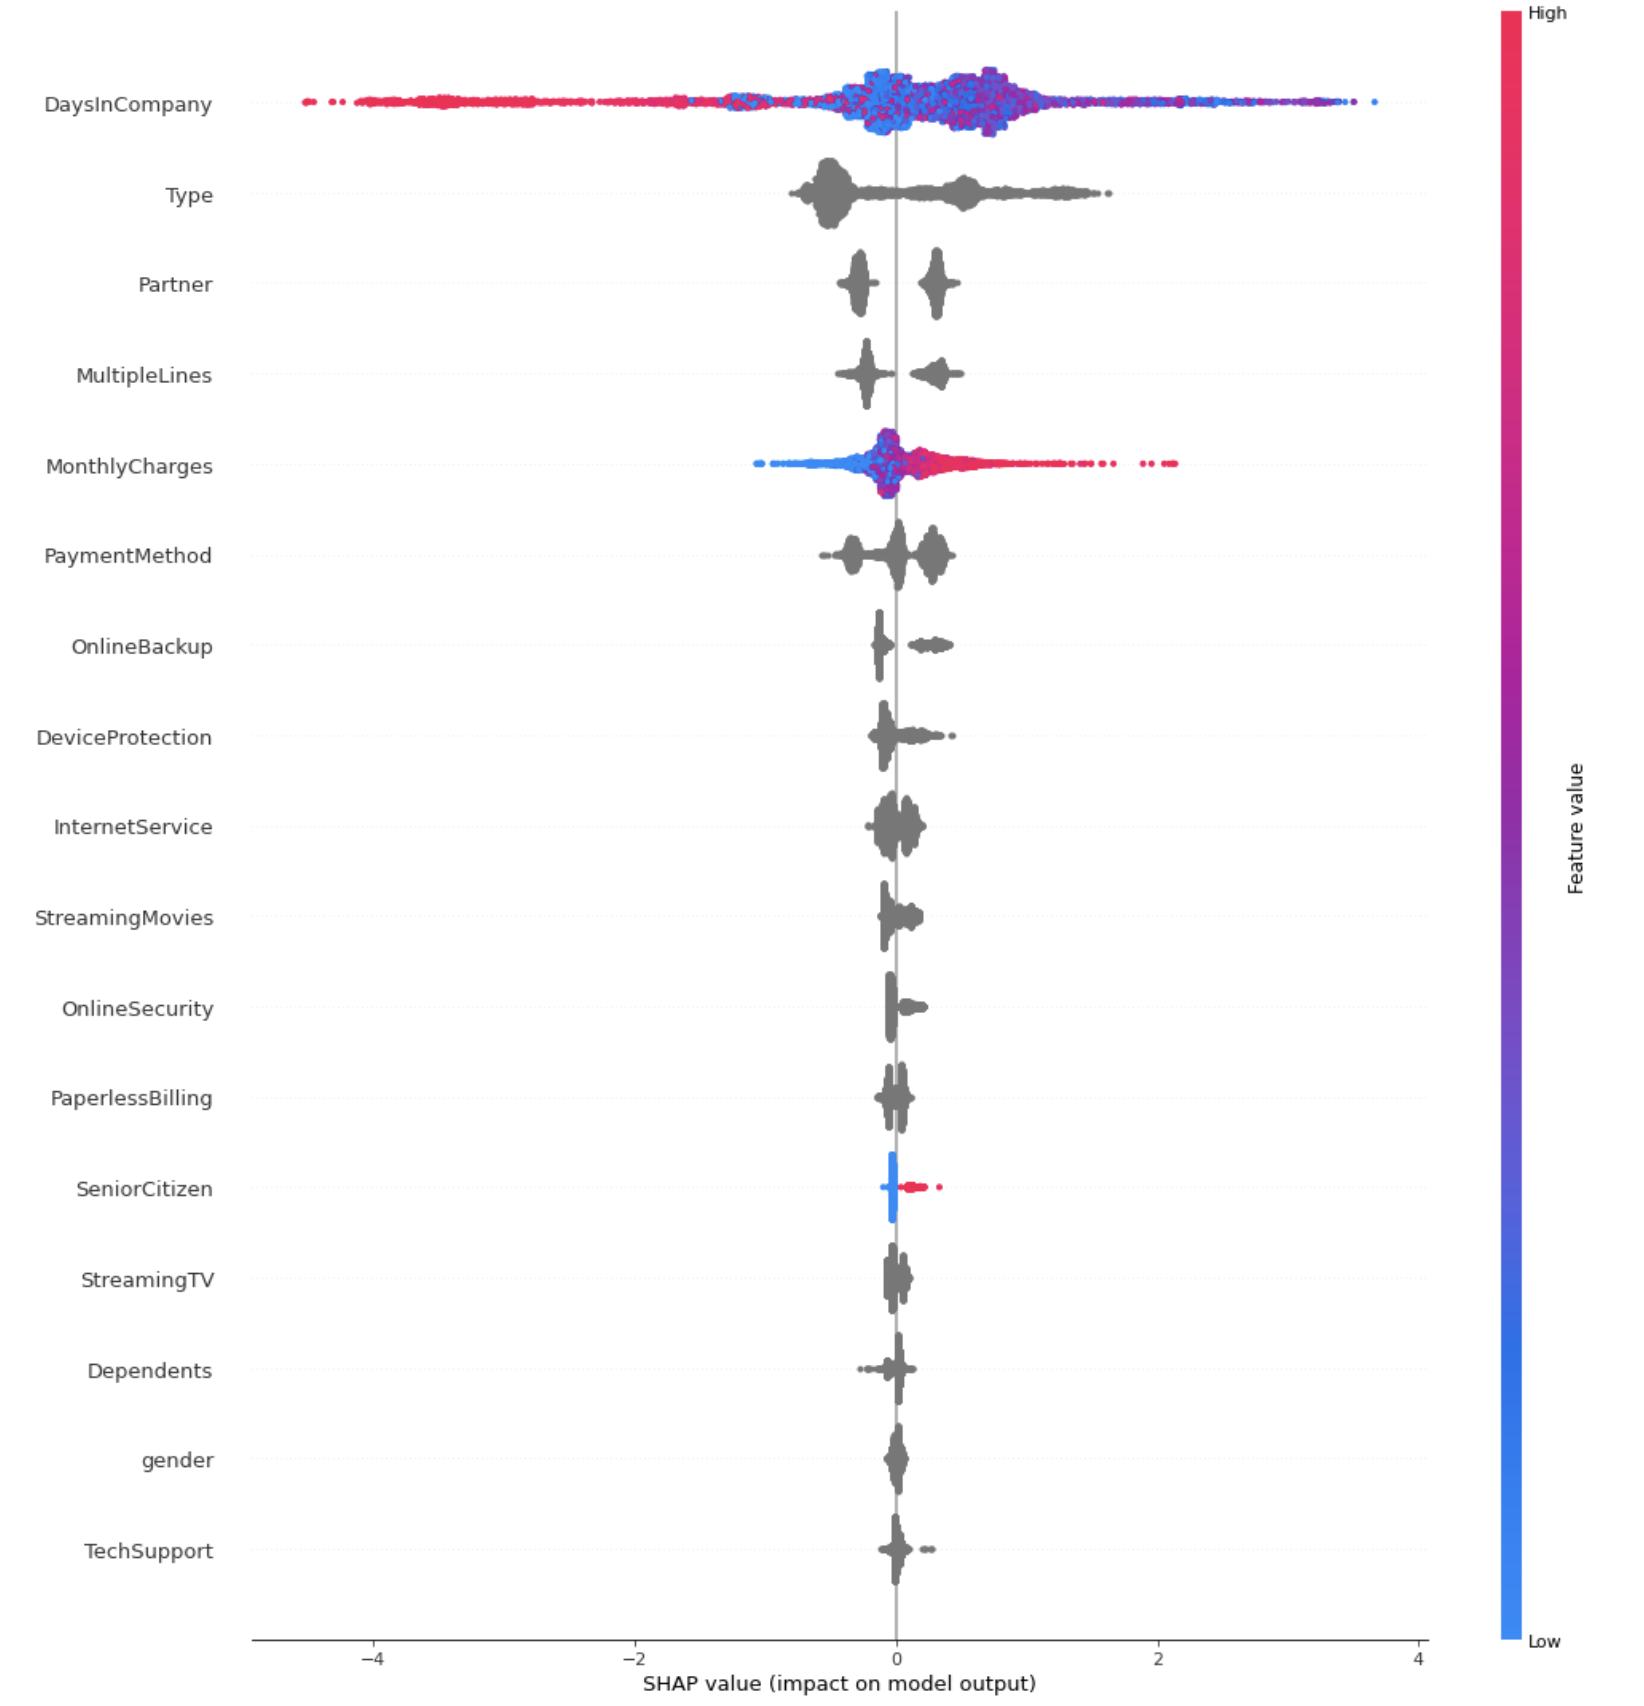
Чем выше ежемесячные траты на услуги по договору (MonthlyCharges), тем выше вероятность ухода клиента.     
Total Charges - всего потрачено денег на услуги. Чем больше потрачено, тем меньше вероятность ухода клиента.То есть если клиент с нами давно и ежемесячный платеж не большой, то скорее всего клиент не уйдет.